# Benchmarking with mlflow

1. Import libraries

In [ ]:
# Import libraries
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 11:14:00 2023

@author: al005366
"""
import logging

# %%
# Import necessary libraries
import os
from datetime import datetime

import pandas as pd
import mlflow
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import tempfile
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import shap

import matplotlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import VAR

import os
import pandas as pd
import mlflow
import mlflow.sklearn
import plotly.graph_objects as go
import plotly.io as pio
import shap
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np
from plotly.subplots import make_subplots

import tempfile
import shap

matplotlib.style.use('ggplot')

# Define the size of the DataFrame
size = 400

2. Read data

In [39]:
df = pd.read_csv('./data/data_processed_quaterly_DE.csv') # fx, pol_rate, cpi_yoy_L1, bankCreditPnfs_yoy_L2
df.set_index(pd.to_datetime(df['date']), inplace=True)
df = df.drop('date', axis=1)
df.head()


,resPropPrice,fx,dsrPnfs,dsrHousehold,dsrNfc,policyRate,UStermSpread,financialStressIndex,fx_std,bankCreditPnfs_yoy_L1,...,totalCreditPnfs2GDP_yoy_L1,bankCreditPnfs_yoy_L2,totalCreditPnfsLCY_yoy_L2,totalCreditPnfs2GDP_yoy_L2,cpi_yoy_L1,financialConditionIndex,EAtermspread,USpolicyRate,financialStressIndex_movingAverage,is_systemic_crisis
date,,,,,,,,,,,,,,,,,,,,,
1970-04-01,123.2700,1.860088,NaN,NaN,NaN,7.500000,NaN,0.10604,0.161265,15.414753,...,1.822600,15.841755,15.365390,2.916160,2.929191,NaN,NaN,7.882755,NaN,0.0
1970-07-01,124.3391,1.856615,NaN,NaN,NaN,7.085859,NaN,0.10064,0.038282,15.830040,...,1.334951,15.414753,14.502976,1.822600,3.368295,NaN,NaN,6.698687,NaN,0.0
1970-10-01,124.7134,1.858916,NaN,NaN,NaN,6.616162,NaN,0.05876,0.024770,14.827194,...,0.607533,15.830040,14.855307,1.334951,3.503313,NaN,NaN,5.577475,NaN,0.0
1971-01-01,125.7255,1.857594,NaN,NaN,NaN,6.000000,NaN,0.06502,0.003036,9.975039,...,-1.298701,14.827194,14.103921,0.607533,3.945319,NaN,NaN,3.850825,NaN,0.0
1971-04-01,129.8377,1.826105,NaN,NaN,NaN,5.000000,NaN,0.06414,0.031660,9.517005,...,-1.789976,9.975039,11.554189,-1.298701,4.267882,NaN,NaN,4.551020,NaN,0.0


3. Choose regressors and target variable

In [40]:
regressors = [ 'fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']
target = 'financialStressIndex_movingAverage'

4. Define all the different model specifications

In [41]:
# Define model specifications
mod_1 = ['fx']
mod_2 = mod_1 + ['policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']
mod_3 = mod_1 + ['policyRate']
mod_4 = mod_1 + ['bankCreditPnfs_yoy_L2']

#mod_6 = mod_2 + 'USpolicyRate'

# Store models in a dictionary
models = {
    'model_1': mod_1,
    'model_2': mod_2,
    'model_3': mod_3,
    'model_4': mod_4
 #   'model_5': mod_5,
}

5. Define training and test data

In [43]:
# Define training and test dates
train_start_date = '1972-10-01'
train_end_date = '2015-12-01'
test_start_date_1 = '2016-01-01'
test_end_date_1 = '2024-01-01'

# Split the data into training and testing sets
df_train = df.loc[(df.index >= train_start_date) & (df.index <= train_end_date), :].copy()
train_x = {mname: pd.DataFrame() for mname in models.keys()}
# Populate train_x with training data
for mname, varsname in models.items():
    train_x[mname] = df_train[varsname].dropna().copy()
    train_x[mname] = sm.add_constant(train_x[mname])

df_test_1 = df.loc[(df.index >= test_start_date_1) & (df.index <= test_end_date_1), :].copy()
test_x_1 = {mname: pd.DataFrame() for mname in models.keys()}
# Populate test_x_1 with test data
for mname, varsname in models.items():
    test_x_1[mname] = df_test_1[varsname].dropna().copy()
    test_x_1[mname] = sm.add_constant(test_x_1[mname])


# Define the target variable
y = df[['financialStressIndex_movingAverage']].copy()
train_y = y[y.index.isin(df_train[varsname].dropna().index.tolist())].copy()
test_y_1 = df['financialStressIndex_movingAverage'][df.index.isin(df_test_1.index.tolist())].copy()
#test_y_2 = df['financialConditionIndex'][df.index.isin(df_test_2.index.tolist())].copy()

test_x = test_x_1
test_y = test_y_1
test_y_1 = pd.DataFrame(test_y_1)
test_y = pd.DataFrame(test_y_1)

6. Select ML/econometrics models and define hyperparameters

In [44]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models and hyperparameters for benchmarking
ridge_model = Ridge()
ridge_params_grid = {"alpha": [100, 1e0, 1e-5]}

kernel_ridge_model = KernelRidge()
kr_params_grid = {"alpha": [100, 1e0, 1e-5],
                "kernel": ['linear', 'rbf'],
                "gamma": [1e0, 1e-5]}

rf_model = RandomForestRegressor()
rf_params_grid = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'n_estimators': [100, 1000],
    'random_state': [0]
}

gbr_model = GradientBoostingRegressor()
gbr_params_grid = {
    "n_estimators": [10, 500],
    "learning_rate": [0.0001, 1.0],
    "loss": ["squared_error"],
    "random_state": [0]
}

xgb_model = xgb.XGBRegressor()
xgb_params_grid = {
    'subsample': [1],
    'max_depth': [3, 5],
    'gamma': np.linspace(0, 1, 3),
    'colsample_bytree': [0.15]
}

mlp_model = MLPRegressor(max_iter=1000)
mlp_params_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 200)],
    'activation': ['tanh'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0, 0.05],
    'learning_rate': ['constant'],
}

benchmarking_dict = {
    'rf': {'model': rf_model, 'param_grid': rf_params_grid},
    'ridge':{'model': ridge_model, 'param_grid': ridge_params_grid},
    #'kernel_ridge': {'model': kernel_ridge_model, 'param_grid': kr_params_grid},
    #'gbr':{'model': gbr_model, 'param_grid': gbr_params_grid},
    'xgb': {'model': xgb_model, 'param_grid': xgb_params_grid},
    #'mlp': {'model': mlp_model, 'param_grid': mlp_params_grid}
}

benchmarking_dict = {
    'ols': {'model': None, 'param_grid': None},
    #'var': {'model': None, 'param_grid': None},
    #'ridge': {'model': ridge_model, 'param_grid': ridge_params_grid},
  #  'kernel_ridge': {'model': kernel_ridge_model, 'param_grid': kr_params_grid},
    'rf': {'model': rf_model, 'param_grid': rf_params_grid},
  #  'gbr': {'model': gbr_model, 'param_grid': gbr_params_grid},
    'xgb': {'model': xgb_model, 'param_grid': xgb_params_grid},
   # 'mlp': {'model': mlp_model, 'param_grid': mlp_params_grid}
}

# Specify horizons and metrics
# horizon = ['1m', '3m', '12m']
metric = ['r2', 'rmse_1']

# Create a dictionary to store results
res = dict()

In [45]:
wd = os.getcwd()
mlflow.set_tracking_uri(f"sqlite:///{wd}/mlflow/mlflow.db")
wd
# mlflow ui --port 5000 --backend-store-uri sqlite:///C:/git/eu_sdfa_forecastingTools/mlflow/mlflow.db

7. Define experiment for mlflow

In [47]:
# Get the current date
today = datetime.today().date().isoformat()
today_str = today.replace('-', '')

# Define experiment name
experiment_name = f"{today}-benchmarking-eusdfa-123"

# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    experiment_id = experiment.experiment_id
else:
    # Create the experiment
    experiment_id = mlflow.create_experiment(experiment_name)

print(f"Using experiment ID: {experiment_id}")

Using experiment ID: 3


8. Define function for benchmarking

In [48]:
def benchmark_model(benchmarking_dict, models, train_x, train_y, test_x_1, test_y_1, tscv, metric, today_str, experiment_id, use_shap):
    res = dict()
    plots_dir = "plots"
    os.makedirs(plots_dir, exist_ok=True)
    
    target_column = train_y.columns[0]
    
    # Loop through each model for benchmarking
    for model in benchmarking_dict.keys():
        # Initialize results dataframe         
        res[model] = pd.DataFrame(index=models.keys(), columns=metric)
        
        # Loop through each model specification
        for modname, modvars in models.items():
            # Start an MLflow run
            with mlflow.start_run(run_name=f"inflation-{today_str}-{model}-{target_column}-{modname}", experiment_id=experiment_id):
                # Logging information    
                print(f'\n Model: {model} \n Spec: {modname} \n Spec vars: {modvars}')
                mlflow.log_param("Model", model)
                mlflow.log_param("Spec", modname)
                mlflow.log_param("Spec_vars", modvars)

                # Fit and predict using the appropriate library
                if model in ['ols', 'var']:
                    if model == 'ols':
                        ols_model = sm.OLS(train_y[target_column], train_x[modname])
                        res_fit = ols_model.fit()
                        pred_o = res_fit.predict(sm.add_constant(test_x_1[modname][train_x[modname].columns]))
                        pred_i = res_fit.predict(sm.add_constant(train_x[modname]))
                        best_params = None
                    elif model == 'var':
                        cols2var = modvars  # Use current model's variables for VAR
                        train_data = train_x[cols2var].dropna().copy()
                        test_data = test_x_1[cols2var].dropna().copy()
                        var_model = VAR(train_data)
                        res_fit = var_model.fit(1)
                        pred_o = res_fit.forecast(train_data.values[-1:], len(test_data))
                        pred_i = res_fit.fittedvalues
                        best_params = None
                else:
                    # Grid search for hyperparameter tuning
                    model_paramSearch = GridSearchCV(benchmarking_dict[model]['model'], 
                                                     param_grid=benchmarking_dict[model]['param_grid'],
                                                     cv=tscv)
                    model_paramSearch.fit(train_x[modname], train_y[target_column])
                    best_params = model_paramSearch.best_params_

                    # Fit the model with the best hyperparameters
                    res_fit = benchmarking_dict[model]['model'].set_params(**model_paramSearch.best_params_).fit(train_x[modname], train_y[target_column])

                    # Make predictions on test data
                    pred_o = res_fit.predict(test_x_1[modname])
                    pred_i = res_fit.predict(train_x[modname])

                # Log the resulting model
                mlflow.sklearn.log_model(res_fit, "model")

                # Log the best parameters
                if best_params:
                    for param, value in best_params.items():
                        mlflow.log_param(param, value)
                
                try:
                    coeff_ = pd.DataFrame(res_fit.coef_, index=train_x[modname].columns, columns=['coeff'])
                except Exception:
                    coeff_ = []
                
                # Calculate evaluation metrics
                r2 = r2_score(train_y[target_column], pred_i)
                rmse_1 = mean_squared_error(test_y_1[target_column], pred_o, squared=False)
                res[model].loc[modname, 'r2'] = r2
                res[model].loc[modname, 'rmse_1'] = rmse_1

                # Log metrics
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("rmse_1", rmse_1)

                # Compute and log permutation importance
                if model not in ['ols', 'var']:
                    perm_imp = permutation_importance(res_fit, test_x_1[modname], test_y_1[target_column], n_repeats=10, random_state=0, n_jobs=2)
                    perm_imp_df = pd.DataFrame(perm_imp.importances[:].T, columns=test_x_1[modname].columns)
                    
                    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                        perm_imp_df.to_csv(tempf.name, index=False)
                        mlflow.log_artifact(tempf.name, "permutation_importance.csv")
                
                    plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)
                    plt.title(f"{model} permutation Importance (test set)")
                    plt.tight_layout()
                    plot_filename = f"{plots_dir}/{model}_perm_imp_{modname}.png"
                    plt.savefig(plot_filename)
                    plt.close()
                    mlflow.log_artifact(plot_filename)

                shap_values = None
                if use_shap and model not in ['ols', 'var']:
                    # Compute and log SHAP values
                    try:
                        explainer = shap.Explainer(res_fit)
                        shap_values = explainer(train_x[modname])
                        shap_values_test = explainer(test_x_1[modname])
                        
                        plt.subplot(211)
                        shap.plots.beeswarm(shap_values, show=False, max_display=10)
                        plt.subplot(212)
                        shap.plots.bar(shap_values, show=False, max_display=10)
                        plt.suptitle(f"{model} SHAP")
                        plt.tight_layout()
                        plot_filename = f"{plots_dir}/{model}_shap_{modname}.png"
                        plt.savefig(plot_filename)
                        plt.close()
                        mlflow.log_artifact(plot_filename)

                        shap.summary_plot(shap_values, train_x[modname], show=False)
                        plt.title(f"{model} SHAP")
                        plt.tight_layout()
                        plot_summary_filename = f"{plots_dir}/{model}_shapSummary_{modname}.png"
                        plt.savefig(plot_summary_filename)
                        plt.close()
                        mlflow.log_artifact(plot_summary_filename)
                        
                        shap_values_df = pd.DataFrame(shap_values.values, columns=train_x[modname].columns)
                        with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                            shap_values_df.to_csv(tempf.name, index=False)
                            mlflow.log_artifact(tempf.name, "shap_values.csv")
                    except Exception as e:
                        print(e)
    
        # Uncomment to save results to an Excel file        
        # res[model].to_excel(res_folder + f'{model}_V2.xlsx', sheet_name='data')

    # Uncomment to save overall results to a pickle file               
    # with open(res_folder + '\\results_models_V2.pkl', 'wb') as f:
    #    pickle.dump(res, f)

    print("Experiment completed and logged.")


 Model: ols 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:30:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

Experiment completed and logged.

 Model: ols 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:31:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:32:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:33:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_1 
 Spec vars: ['fx']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:33:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:33:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:33:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2']


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/09/24 12:33:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

Experiment completed and logged.


9. Execute benchmarking

In [ ]:
# Usage:
# Call this function with use_shap=True to include SHAP values, or use_shap=False to exclude SHAP values.
benchmark_model(benchmarking_dict, models, train_x, train_y, test_x_1, test_y_1, tscv, metric, today_str, experiment_id, use_shap=True)
benchmark_model(benchmarking_dict, models, train_x, train_y, test_x_1, test_y_1, tscv, metric, today_str, experiment_id, use_shap=False)

10. Read best result (eg by R-squared)

In [49]:
# Get the experiment ID
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
print(experiment_id)

# Search for the runs in the experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Find the best run based on R² metric
best_run = runs.loc[runs["metrics.r2"].idxmax()]
print(best_run)
run_id = best_run["run_id"]

# Load the best model
path = f"runs:/{run_id}/model"
model = mlflow.sklearn.load_model(path)
print(model)


3
run_id                                            60ce1a25a2f249718f5107150ed24350
experiment_id                                                                    3
status                                                                    FINISHED
artifact_uri                     file:///c:/git/eu_sdfa_forecastingTools/mlruns...
start_time                                        2024-09-24 10:32:23.288000+00:00
end_time                                          2024-09-24 10:32:41.240000+00:00
metrics.r2                                                                 0.95415
metrics.rmse_1                                                            0.036423
params.max_depth                                                                80
params.subsample                                                              None
params.colsample_bytree                                                       None
params.Spec                                                                model_2
pa

Actual vs prediction and various metrics

Best model specification: model_2


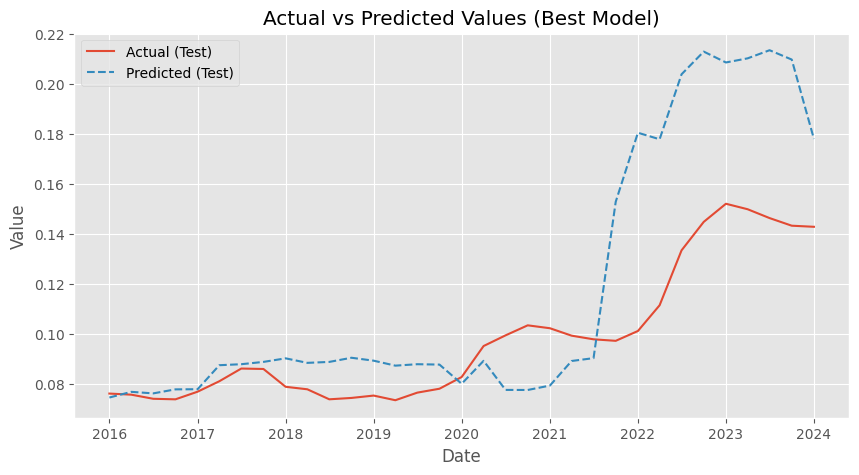

C:\Users\al005366\AppData\Local\Temp\2\ipykernel_32740\1483626212.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)


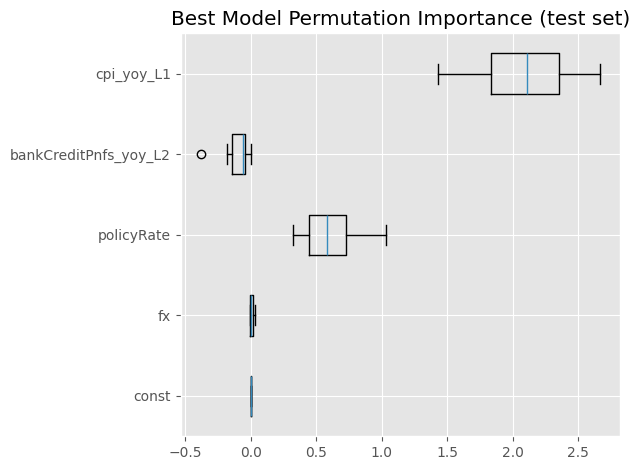

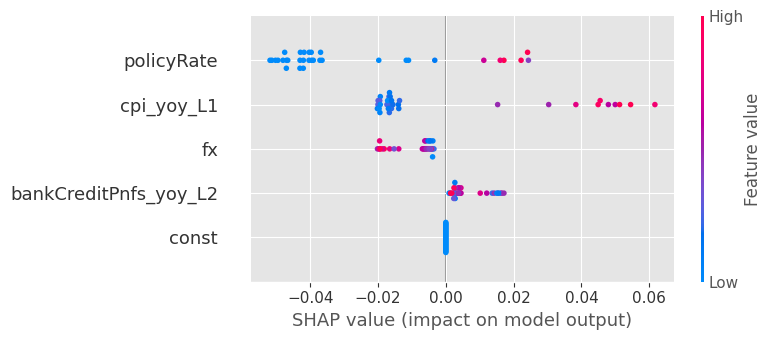

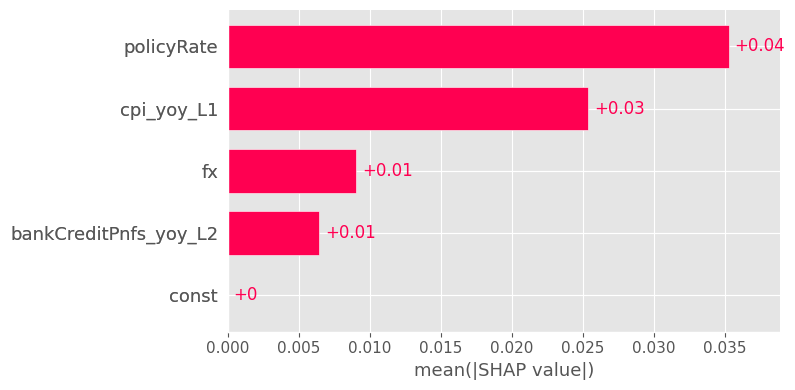

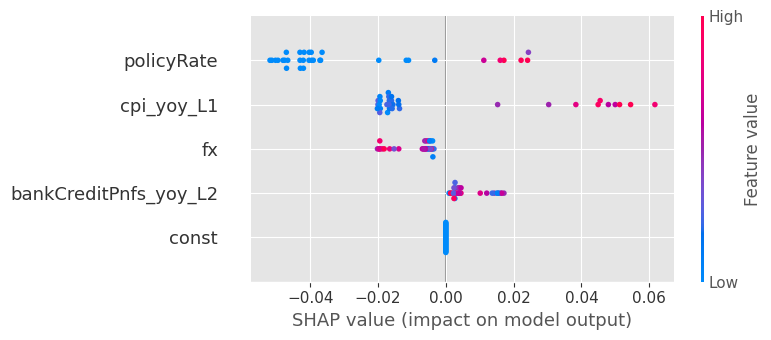

<Figure size 640x480 with 0 Axes>

In [15]:
# Retrieve the model specification from the best run's parameters
model_spec = best_run["params.Spec"]
print(f"Best model specification: {model_spec}")

# Predict on the test data using the best model
pred_best = model.predict(test_x_1[model_spec])
pred_best_df = pd.DataFrame(index=test_y_1.index, columns=['pred'])
pred_best_df['pred'] = pred_best

# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 5))
plt.plot(test_y_1, label='Actual (Test)')
plt.plot(pred_best_df.index, pred_best_df['pred'], label='Predicted (Test)', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Best Model)')
plt.show()

# Plot permutation importance for the best model
perm_imp = permutation_importance(model, test_x_1[model_spec], test_y_1, n_repeats=10, random_state=0, n_jobs=2)
perm_imp_df = pd.DataFrame(perm_imp.importances[:].T, columns=test_x_1[model_spec].columns)

plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)
plt.title(f"Best Model Permutation Importance (test set)")
plt.tight_layout()
plt.show()

# Plot SHAP values for the best model
explainer = shap.Explainer(model)
shap_values = explainer(test_x_1[model_spec])

plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values, show=False, max_display=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values, show=False, max_display=10)
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, test_x_1[model_spec])
plt.tight_layout()
plt.show()

Regressors

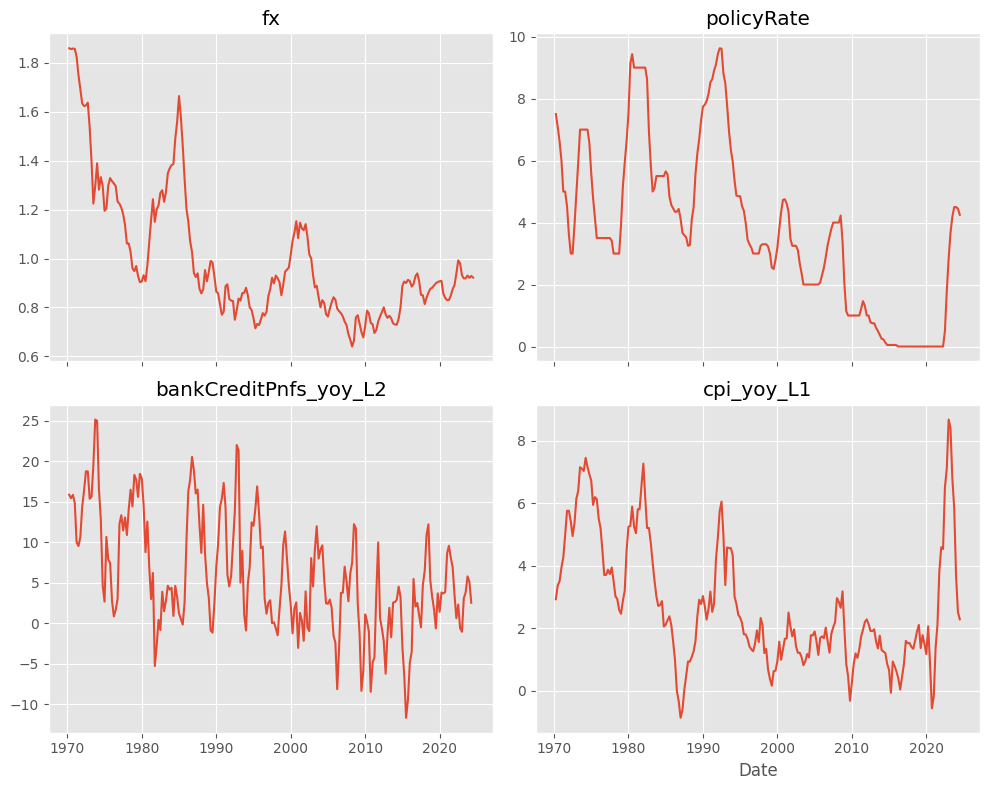

In [16]:
# Plot the time series of the variables used as inputs for the best model in a single figure with subplots
input_vars = models[model_spec]
num_vars = len(input_vars)

# Determine the grid size for the subplots
cols = int(np.ceil(np.sqrt(num_vars)))
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharex=True)
axes = axes.flatten()

for i, var in enumerate(input_vars):
    axes[i].plot(df.index, df[var], label=var)
    #axes[i].legend()
    #axes[i].set_ylabel('Value')
    axes[i].set_title(f'{var}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

11. Create HTML report of the resulst

In [18]:
# Create an HTML file for the plots
html_file = 'model_evaluation.html'
plots_dir = "plots"
# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 5))
plt.plot(test_y_1, label='Actual (Test)', color='green')
plt.plot(pred_best_df.index, pred_best_df['pred'], label='Predicted (Test)', linestyle='--', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Best Model)')
actual_vs_pred_path = os.path.join(plots_dir, 'actual_vs_pred.png')
plt.savefig(actual_vs_pred_path)
plt.close()

# Plot permutation importance for the best model
perm_imp = permutation_importance(model, test_x_1[model_spec], test_y_1, n_repeats=10, random_state=0, n_jobs=2)
perm_imp_df = pd.DataFrame(perm_imp.importances[:].T, columns=test_x_1[model_spec].columns)

plt.figure(figsize=(10, 5))
plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)
plt.title('Best Model Permutation Importance (test set)')
perm_imp_path = os.path.join(plots_dir, 'perm_importance.png')
plt.savefig(perm_imp_path)
plt.close()

# Plot SHAP values for the best model
explainer = shap.Explainer(model)
shap_values = explainer(test_x_1[model_spec])

# SHAP Beeswarm Plot
plt.figure(figsize=(10, 5))
shap.plots.beeswarm(shap_values, show=False)
plt.title('SHAP Beeswarm')
shap_beeswarm_path = os.path.join(plots_dir, 'shap_beeswarm.png')
plt.savefig(shap_beeswarm_path)
plt.close()

# SHAP Bar Plot
plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values, show=False)
plt.title('SHAP Bar')
shap_bar_path = os.path.join(plots_dir, 'shap_bar.png')
plt.savefig(shap_bar_path)
plt.close()

# SHAP Summary Plot
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, test_x_1[model_spec], show=False)
plt.title('SHAP Summary')
shap_summary_path = os.path.join(plots_dir, 'shap_summary.png')
plt.savefig(shap_summary_path)
plt.close()

# Plot the time series of the variables used as inputs for the best model in a single figure with subplots
input_vars = models[model_spec]
num_vars = len(input_vars)

# Determine the grid size for the subplots
cols = int(np.ceil(np.sqrt(num_vars)))
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i, var in enumerate(input_vars):
    axes[i].plot(df.index, df[var], label=var)
    axes[i].legend()
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'Time Series of {var}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel('Date')
plt.tight_layout()
time_series_path = os.path.join(plots_dir, 'input_vars_time_series.png')
plt.savefig(time_series_path)
plt.close()

# Create an HTML file to embed the plots
html_file = 'model_evaluation.html'

with open(html_file, 'w') as f:
    f.write('<html><head><title>Model Evaluation</title></head><body>')
    f.write('<h1>Model Evaluation Results</h1>')

    # Embed Actual vs Predicted plot
    f.write('<h2>Actual vs Predicted Values (Best Model)</h2>')
    f.write(f'<img src="{actual_vs_pred_path}" alt="Actual vs Predicted Values"><br><br>')

    # Embed Permutation Importance plot
    f.write('<h2>Permutation Importance</h2>')
    f.write(f'<img src="{perm_imp_path}" alt="Permutation Importance"><br><br>')

    # Embed SHAP Beeswarm plot
    f.write('<h2>SHAP Beeswarm Plot</h2>')
    f.write(f'<img src="{shap_beeswarm_path}" alt="SHAP Beeswarm Plot"><br><br>')

    # Embed SHAP Bar plot
    f.write('<h2>SHAP Bar Plot</h2>')
    f.write(f'<img src="{shap_bar_path}" alt="SHAP Bar Plot"><br><br>')

    # Embed SHAP Summary plot
    f.write('<h2>SHAP Summary Plot</h2>')
    f.write(f'<img src="{shap_summary_path}" alt="SHAP Summary Plot"><br><br>')

    # Embed Time Series plot
    f.write('<h2>Time Series of Input Variables</h2>')
    f.write(f'<img src="{time_series_path}" alt="Time Series of Input Variables"><br><br>')

    f.write('</body></html>')

print(f"Plots saved to {html_file}")


C:\Users\al005366\AppData\Local\Temp\2\ipykernel_32740\2902580889.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)


Plots saved to model_evaluation.html
